In [1]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
from keras.utils.np_utils import to_categorical
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Flatten, Dense, Dropout
from keras.layers import MaxPooling2D, ZeroPadding2D
from keras.layers.convolutional import Convolution2D
from keras.layers.core import Activation
from keras import backend as K
from keras.utils import np_utils
%matplotlib inline
keras.__version__
import tensorflow as tf
tf.__version__

Using TensorFlow backend.


'1.13.1'

In [2]:
USE_GPU = True

if USE_GPU:
    device = '/device:GPU:0'
else:
    device = '/cpu:0'

# # Constant to control how often we print when training models
# print_every = 100

print('Using device: ', device)

Using device:  /device:GPU:0


In [4]:
# Data loading + reshape to 4D
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# introduce 10% noise into training labels
# print(len(y_train))
noise_level = 0.0001
y_train_noise = y_train.copy()
for i in np.random.choice(len(y_train), int(noise_level * len(y_train)), replace = False):
    flag = True
    while flag:
        a = np.random.randint(0,10)
        if y_train_noise[i] != a:
            y_train_noise[i] = a
            flag = False
            
            
diff = y_train_noise-y_train
indx = np.where(diff!=0)
print(1-(len(diff[diff!=0]))/len(diff)) # 0.9
noisy_image_idx = indx[0][0]

X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

X_train/=255
X_test/=255

print(X_train.shape)
print(X_test.shape)

num_training=55000
num_validation=5000
num_test=10000

mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val_noise = y_train_noise[mask]
mask = range(num_training)
X_train = X_train[mask]
y_train_noise = y_train_noise[mask]
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

# print(X_val.shape)
# print(X_train.shape)
# X_train_orignal = np.concatenate((X_val,X_train))
# print(X_train_orignal.shape)

mean_pixel = X_train.mean(axis=(0, 1, 2), keepdims=True)
std_pixel = X_train.std(axis=(0, 1, 2), keepdims=True)
X_train = (X_train - mean_pixel) / std_pixel
X_val = (X_val - mean_pixel) / std_pixel
X_test = (X_test - mean_pixel) / std_pixel

print(X_train.shape)
print(X_val.shape)
print(y_train_noise.shape)
print(y_val_noise.shape)
X_train_all = np.concatenate((X_train,X_val))
y_train_noise_all = np.concatenate((y_train_noise,y_val_noise))
print(X_train_all.shape)
print(y_train_noise_all.shape)

0.9999
(60000, 28, 28, 1)
(10000, 28, 28, 1)
(55000, 28, 28, 1)
(5000, 28, 28, 1)
(55000,)
(5000,)
(60000, 28, 28, 1)
(60000,)


6


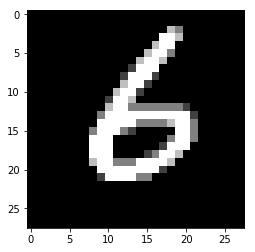

In [5]:
plt.imshow(np.squeeze(X_train[66]), cmap='gray')
print(y_train_noise[66])

In [6]:
number_of_classes = 10

Y_train = to_categorical(y_train_noise, number_of_classes)
Y_val = to_categorical(y_val_noise, number_of_classes)
Y_test = to_categorical(y_test, number_of_classes)

print(Y_train.shape)
# Y_train_noise = to_categorical(y_train_noise, number_of_classes)

y_train_noise[1], Y_train[1]

(55000, 10)


(0, array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32))

In [7]:
# def load_mnist(num_training=49000, num_validation=1000, num_test=10000):
#     mnist = mnist.load_data()
#     (X_train, y_train), (X_test, y_test) = mnist
#     X_train = np.asarray(X_train, dtype=np.float32)
#     y_train = np.asarray(y_train, dtype=np.int32).flatten()
#     X_test = np.asarray(X_test, dtype=np.float32)
#     y_test = np.asarray(y_test, dtype=np.int32).flatten()

# #     Subsample the data
#     mask = range(num_training, num_training + num_validation)
#     X_val = X_train[mask]
#     y_val = y_train[mask]
#     mask = range(num_training)
#     X_train = X_train[mask]
#     y_train = y_train[mask]
#     mask = range(num_test)
#     X_test = X_test[mask]
#     y_test = y_test[mask]

#     # Normalize the data: subtract the mean pixel and divide by std
#     mean_pixel = X_train.mean(axis=(0, 1, 2), keepdims=True)
#     std_pixel = X_train.std(axis=(0, 1, 2), keepdims=True)
#     X_train = (X_train - mean_pixel) / std_pixel
#     X_val = (X_val - mean_pixel) / std_pixel
#     X_test = (X_test - mean_pixel) / std_pixel

#     return X_train, y_train, X_val, y_val, X_test, y_test

# X_train, y_train, X_val, y_val, X_test, y_test = load_mnist()

class Dataset(object):
    def __init__(self, X, y, batch_size, shuffle=False):
        assert X.shape[0] == y.shape[0], 'Got different numbers of data and labels'
        self.X, self.y = X, y
        self.batch_size, self.shuffle = batch_size, shuffle

    def __iter__(self):
        N, B = self.X.shape[0], self.batch_size
        idxs = np.arange(N)
        if self.shuffle:
            np.random.shuffle(idxs)
        return iter((self.X[i:i+B], self.y[i:i+B]) for i in range(0, N, B))

train_dset = Dataset(X_train, y_train_noise, batch_size=64, shuffle=True)
val_dset = Dataset(X_val, y_val_noise, batch_size=64, shuffle=False)
test_dset = Dataset(X_test, y_test, batch_size=64)

def check_accuracy(sess, dset, x, scores, is_training=None):
    num_correct, num_samples = 0, 0
    for x_batch, y_batch in dset:
        feed_dict = {x: x_batch, is_training: 0}
        scores_np = sess.run(scores, feed_dict=feed_dict)
        y_pred = scores_np.argmax(axis=1) 
        num_samples += x_batch.shape[0]
        num_correct += (y_pred == y_batch).sum()
    acc = float(num_correct) / num_samples
    print('Got %d / %d correct (%.2f%%)' % (num_correct, num_samples, 100 * acc))
    return acc
    
def train_noisyCNN(model_init_fn, optimizer_init_fn, num_epochs=1):
    tf.reset_default_graph()
    with tf.device(device):
        x = tf.placeholder(tf.float32, [None, 28, 28, 1])
        y = tf.placeholder(tf.int32, [None])
        
        is_training = tf.placeholder(tf.bool, name='is_training')
        
        scores, scores_2 = model_init_fn(x, is_training)

        loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=scores)
        loss = tf.reduce_mean(loss)
        loss_2 = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=scores_2)
        loss_2 = tf.reduce_mean(loss_2)

        optimizer = optimizer_init_fn()
        update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
        with tf.control_dependencies(update_ops):
            train_op = optimizer.minimize(loss)
            train_op_2 = optimizer.minimize(loss_2)

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        t = 0
        for epoch in range(num_epochs):
            print('Starting epoch %d' % epoch)
            for x_np, y_np in train_dset:
                feed_dict = {x: x_np, y: y_np, is_training:1}
                loss_np, _ = sess.run([loss, train_op], feed_dict=feed_dict)
                loss_np_2, _ = sess.run([loss_2, train_op_2], feed_dict=feed_dict)
                if t % print_every == 0:
                    print('Iteration %d, loss = %.4f' % (t, loss_np))
                    print('Iteration %d, loss_2 = %.4f' % (t, loss_np_2))
                    check_accuracy(sess, val_dset, x, scores, is_training=is_training)
                    check_accuracy(sess, val_dset, x, scores_2, is_training=is_training)
                    print()
                t += 1
                
        print('model 1 test accuracy:')
        check_accuracy(sess, test_dset, x, scores, is_training=is_training)
        print('model 2 test accuracy:')
        check_accuracy(sess, test_dset, x, scores_2, is_training=is_training)

def model_init_fn(inputs, is_training):
#     initializer = tf.variance_scaling_initializer(scale=2.0)
    model = Sequential()
    model.add(Convolution2D(32, kernel_size=(3, 3), input_shape=(28,28,1)))
    convout1 = Activation('relu')
    model.add(convout1)
    convout2 = MaxPooling2D()
    model.add(convout2)
    model.add(Flatten())
    model.add(Dense(128))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(Dense(10))
    model.add(Activation('softmax'))
    model.summary()
    
    model_2 = Sequential()
    model_2.add(Convolution2D(32, kernel_size=(3, 3), input_shape=(28,28,1)))
    convout1_2 = Activation('relu')
    model_2.add(convout1)
    convout2_2 = MaxPooling2D()
    model_2.add(convout2)
    model_2.add(Flatten())
    model_2.add(Dense(128))
    model_2.add(Activation('relu'))
    model_2.add(Dropout(0.2))
    model_2.add(Dense(10))
    model_2.add(Activation('softmax'))
    model_2.summary()
    
    return model(inputs), model_2(inputs)

learning_rate = 4e-4

def optimizer_init_fn():
    optimizer=tf.train.AdamOptimizer(learning_rate=learning_rate)
    return optimizer

print_every = 700
num_epochs = 2
train_noisyCNN(model_init_fn, optimizer_init_fn, num_epochs)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
activation_1 (Activation)    (None, 26, 26, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 5408)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               692352    
_________________________________________________________________
activation_2 (Activat

In [19]:
#testing cell
import numpy as np
a=np.array([i for i in range(100)])
print(a.shape)
cnt=0
for aa in iter(a[i:i+10] for i in range(0, 100, 10)):
#     print(aa.shape) # (10,)
    if cnt==0:
        c=aa
    else:
        c=np.vstack((c,aa))
    cnt+=1
print(c)

(100,)
[[ 0  1  2  3  4  5  6  7  8  9]
 [10 11 12 13 14 15 16 17 18 19]
 [20 21 22 23 24 25 26 27 28 29]
 [30 31 32 33 34 35 36 37 38 39]
 [40 41 42 43 44 45 46 47 48 49]
 [50 51 52 53 54 55 56 57 58 59]
 [60 61 62 63 64 65 66 67 68 69]
 [70 71 72 73 74 75 76 77 78 79]
 [80 81 82 83 84 85 86 87 88 89]
 [90 91 92 93 94 95 96 97 98 99]]


In [13]:
#testing cell
def Dataset(X, y, batch_size, shuffle=False):
    N, B = X.shape[0], batch_size
    idxs = np.arange(N)
    if shuffle:
        np.random.shuffle(idxs)
    cnt=0
    it=iter((X[i:i+B], y[i:i+B]) for i in range(0, N, B))
    for (x_batch, y_batch) in it:
        if cnt==0:
            x_dset = x_batch
#             print(x_dset.shape)
            y_dset = y_batch
        else:
            x_dset = np.vstack((x_dset,x_batch))
            y_dset = np.vstack((y_dset,y_batch))
#             print(cnt)
        cnt+=1
    x_dset=x_dset.reshape((-1,batch_size,28,28,1))
    print(x_dset.shape)
    print(y_dset.shape)
    return x_dset, y_dset

# Data loading + reshape to 4D
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# introduce 10% noise into training labels
# print(len(y_train))
noise_level = 0.7
y_train_noise = y_train.copy()
for i in np.random.choice(len(y_train), int(noise_level * len(y_train)), replace = False):
    flag = True
    while flag:
        a = np.random.randint(0,10)
        if y_train_noise[i] != a:
            y_train_noise[i] = a
            flag = False


diff = y_train_noise-y_train
indx = np.where(diff!=0)
print(1-(len(diff[diff!=0]))/len(diff)) # 0.9
noisy_image_idx = indx[0][0]

X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

X_train/=255
X_test/=255

print(X_train.shape)
print(X_test.shape)

num_training=55000
num_validation=5000
num_test=10000

mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val_noise = y_train_noise[mask]
mask = range(num_training)
X_train = X_train[mask]
y_train_noise = y_train_noise[mask]
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

# print(X_val.shape)
# print(X_train.shape)
# X_train_orignal = np.concatenate((X_val,X_train))
# print(X_train_orignal.shape)

mean_pixel = X_train.mean(axis=(0, 1, 2), keepdims=True)
std_pixel = X_train.std(axis=(0, 1, 2), keepdims=True)
X_train = (X_train - mean_pixel) / std_pixel
X_val = (X_val - mean_pixel) / std_pixel
X_test = (X_test - mean_pixel) / std_pixel


number_of_classes = 10

Y_train = to_categorical(y_train_noise, number_of_classes)
Y_val = to_categorical(y_val_noise, number_of_classes)
Y_test = to_categorical(y_test, number_of_classes)

Y_train_noise = to_categorical(y_train_noise, number_of_classes)

y_train_noise[1], Y_train[1]

batch_size=100
x_train_dset, y_train_dset = Dataset(X_train, y_train_noise, batch_size, shuffle=True)
x_val_dset, y_val_dset = Dataset(X_val, y_val_noise, batch_size, shuffle=False)
x_test_dset, y_test_dset = Dataset(X_test, y_test, batch_size)

0.30000000000000004
(60000, 28, 28, 1)
(10000, 28, 28, 1)
(550, 100, 28, 28, 1)
(550, 100)
(50, 100, 28, 28, 1)
(50, 100)
(100, 100, 28, 28, 1)
(100, 100)


In [23]:
#testing cell
x_train_all = np.vstack((x_train_dset, x_val_dset))
x_train_all = x_train_all.reshape((-1,28,28,1))
print(x_train_all.shape)
y_train_all = np.vstack((y_train_dset, y_val_dset))
y_train_all=y_train_all.flatten()
print(y_train_all.shape)

(60000, 28, 28, 1)
(60000,)


In [36]:
#testing cell
for (x,y) in zip(x_train_dset, y_train_dset):
    print(x.shape)
    print(y.shape)

(100, 28, 28, 1)
(100,)
(100, 28, 28, 1)
(100,)
(100, 28, 28, 1)
(100,)
(100, 28, 28, 1)
(100,)
(100, 28, 28, 1)
(100,)
(100, 28, 28, 1)
(100,)
(100, 28, 28, 1)
(100,)
(100, 28, 28, 1)
(100,)
(100, 28, 28, 1)
(100,)
(100, 28, 28, 1)
(100,)
(100, 28, 28, 1)
(100,)
(100, 28, 28, 1)
(100,)
(100, 28, 28, 1)
(100,)
(100, 28, 28, 1)
(100,)
(100, 28, 28, 1)
(100,)
(100, 28, 28, 1)
(100,)
(100, 28, 28, 1)
(100,)
(100, 28, 28, 1)
(100,)
(100, 28, 28, 1)
(100,)
(100, 28, 28, 1)
(100,)
(100, 28, 28, 1)
(100,)
(100, 28, 28, 1)
(100,)
(100, 28, 28, 1)
(100,)
(100, 28, 28, 1)
(100,)
(100, 28, 28, 1)
(100,)
(100, 28, 28, 1)
(100,)
(100, 28, 28, 1)
(100,)
(100, 28, 28, 1)
(100,)
(100, 28, 28, 1)
(100,)
(100, 28, 28, 1)
(100,)
(100, 28, 28, 1)
(100,)
(100, 28, 28, 1)
(100,)
(100, 28, 28, 1)
(100,)
(100, 28, 28, 1)
(100,)
(100, 28, 28, 1)
(100,)
(100, 28, 28, 1)
(100,)
(100, 28, 28, 1)
(100,)
(100, 28, 28, 1)
(100,)
(100, 28, 28, 1)
(100,)
(100, 28, 28, 1)
(100,)
(100, 28, 28, 1)
(100,)
(100, 28, 28, 1)

In [17]:
#testing cell
cnt=0
for idx, (x,y) in enumerate(zip(x_train_dset, y_train_dset)):
    if cnt==0:
        print(idx)
        print(x.shape)
        print(y)
        y_train_dset[idx]=np.zeros(100)
#         print(y)
    cnt+=1

cnt=0
for idx, (x,y) in enumerate(zip(x_train_dset, y_train_dset)):
    if cnt==0:
        print(y)
    cnt+=1

0
(100, 28, 28, 1)
[4 1 4 1 2 5 5 3 7 1 5 2 2 6 4 7 3 8 1 2 3 5 0 9 1 2 4 1 5 4 0 1 8 4 1 1 6
 2 1 8 1 2 0 2 3 9 3 7 2 2 3 2 4 3 0 8 0 0 6 3 0 8 6 2 6 9 1 9 0 9 0 6 2 3
 0 3 2 0 3 8 1 0 2 5 1 2 9 9 6 2 6 7 0 0 5 0 7 3 3 2]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [4]:
# ICL-R: Iterative Cross Learning - Random

def Dataset(X, y, batch_size, shuffle=False):
    N, B = X.shape[0], batch_size
    idxs = np.arange(N)
    if shuffle:
        np.random.shuffle(idxs)
    cnt=0
    it=iter((X[i:i+B], y[i:i+B]) for i in range(0, N, B))
    for (x_batch, y_batch) in it:
        if cnt==0:
            x_dset = x_batch
#             print(x_dset.shape)
            y_dset = y_batch
        else:
            x_dset = np.vstack((x_dset,x_batch))
            y_dset = np.vstack((y_dset,y_batch))
#             print(cnt)
        cnt+=1
    x_dset=x_dset.reshape((-1,batch_size,28,28,1))
#     print(x_dset.shape)
#     print(y_dset.shape)
    return x_dset, y_dset

def check_accuracy(sess, dset, x, scores, is_training=None):
    num_correct, num_samples = 0, 0
    for x_batch, y_batch in dset:
        feed_dict = {x: x_batch, is_training: 0}
        scores_np = sess.run(scores, feed_dict=feed_dict)
        y_pred = scores_np.argmax(axis=1)
        num_samples += x_batch.shape[0]
        num_correct += (y_pred == y_batch).sum()
    acc = float(num_correct) / num_samples
#     print(y_pred)
    print('Got %d / %d correct (%.2f%%)' % (num_correct, num_samples, 100 * acc))
    return acc
    
def cross_check(sess, x_val_dset, y_val_dset, x, scores, scores_2, is_training, flag):
    num_correct, num_correct2, num_samples = 0, 0, 0
    for idx, (x_batch, y_batch) in enumerate(zip(x_val_dset, y_val_dset)):
        feed_dict = {x: x_batch, is_training: 0}
        scores_np = sess.run(scores, feed_dict=feed_dict)
        scores_np_2 = sess.run(scores_2, feed_dict=feed_dict)
        y_pred = scores_np.argmax(axis=1)
        y_pred_2 = scores_np_2.argmax(axis=1)
        if flag: # RUN ICL-RANDOM
            difference = [i - j for i, j in zip(y_pred, y_pred_2)]
            diff_idx = [l for l, e in enumerate(difference) if e != 0]
            for k in diff_idx:
                y_batch[k] = np.random.randint(0,10)
            y_val_dset[idx] = y_batch
        num_samples += x_batch.shape[0]
        num_correct += (y_pred == y_batch).sum()
        num_correct2 += (y_pred_2 == y_batch).sum()
    acc = float(num_correct) / num_samples
    acc2 = float(num_correct2) / num_samples
#     print(y_pred)
    print('model 1: Got %d / %d correct (%.2f%%)' % (num_correct, num_samples, 100 * acc))
    print('model 2: Got %d / %d correct (%.2f%%)' % (num_correct2, num_samples, 100 * acc2))

def train_noisyCNN(model_init_fn, optimizer_init_fn, num_epochs=1):
    
    # Data loading + reshape to 4D
    (X_train, y_train), (X_test, y_test) = mnist.load_data()

    # introduce 10% noise into training labels
    # print(len(y_train))
    noise_level = 0.7 # SET NOISE LEVEL
    y_train_noise = y_train.copy()
    for i in np.random.choice(len(y_train), int(noise_level * len(y_train)), replace = False):
        flag = True
        while flag:
            a = np.random.randint(0,10)
            if y_train_noise[i] != a:
                y_train_noise[i] = a
                flag = False

    diff = y_train_noise-y_train
    indx = np.where(diff!=0)
    print(1-(len(diff[diff!=0]))/len(diff)) # 0.9
    noisy_image_idx = indx[0][0]

    X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
    X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)

    X_train = X_train.astype('float32')
    X_test = X_test.astype('float32')

    X_train/=255
    X_test/=255

#     print(X_train.shape)
#     print(X_test.shape)

    num_training=55000
    num_validation=5000
    num_test=10000
    
    batch_size=100
        
    mask = range(num_training, num_training + num_validation)
    X_val = X_train[mask]
    y_val_noise = y_train_noise[mask]
    mask = range(num_training)
    X_train = X_train[mask]
    y_train_noise = y_train_noise[mask]
    mask = range(num_test)
    X_test = X_test[mask]
    y_test = y_test[mask]

    # print(X_val.shape)
    # print(X_train.shape)
    # X_train_orignal = np.concatenate((X_val,X_train))
    # print(X_train_orignal.shape)

    mean_pixel = X_train.mean(axis=(0, 1, 2), keepdims=True)
    std_pixel = X_train.std(axis=(0, 1, 2), keepdims=True)
    X_train = (X_train - mean_pixel) / std_pixel
    X_val = (X_val - mean_pixel) / std_pixel
    X_test = (X_test - mean_pixel) / std_pixel

#     number_of_classes = 10

#     Y_train = to_categorical(y_train_noise, number_of_classes)
#     Y_val = to_categorical(y_val_noise, number_of_classes)
#     Y_test = to_categorical(y_test, number_of_classes)

#     Y_train_noise = to_categorical(y_train_noise, number_of_classes)

#     y_train_noise[1], Y_train[1]
    
    x_train_dset, y_train_dset = Dataset(X_train, y_train_noise, batch_size, shuffle=True)
    x_val_dset, y_val_dset = Dataset(X_val, y_val_noise, batch_size, shuffle=False)
    x_test_dset, y_test_dset = Dataset(X_test, y_test, batch_size)

    tf.reset_default_graph()
    
    with tf.device(device):
        x = tf.placeholder(tf.float32, [None, 28, 28, 1])
        y = tf.placeholder(tf.int32, [None])
        
        is_training = tf.placeholder(tf.bool, name='is_training')
        
        scores, scores_2 = model_init_fn(x, is_training)

        loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=scores)
        loss = tf.reduce_mean(loss)
        loss_2 = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=scores_2)
        loss_2 = tf.reduce_mean(loss_2)

        optimizer = optimizer_init_fn()
        update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
        with tf.control_dependencies(update_ops):
            train_op = optimizer.minimize(loss)
            train_op_2 = optimizer.minimize(loss_2)

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        t = 0
        for epoch in range(num_epochs):
            if epoch <=1: 
                flag=True
            else: 
                flag=True
            print('Starting epoch %d' % epoch)
            for x_np, y_np in zip(x_train_dset, y_train_dset):
                feed_dict = {x: x_np, y: y_np, is_training:1}
                loss_np, _ = sess.run([loss, train_op], feed_dict=feed_dict)
                loss_np_2, _ = sess.run([loss_2, train_op_2], feed_dict=feed_dict)
                if t % print_every == 0:
                    print('Iteration %d, loss = %.4f' % (t, loss_np))
                    print('Iteration %d, loss_2 = %.4f' % (t, loss_np_2))
                    cross_check(sess, x_val_dset, y_val_dset, x, scores, scores_2, is_training, flag)
                    print()
                t += 1
            # reshuffle data to train/val for each epoch
            print('reshuffling data..')
            x_train_all = np.vstack((x_train_dset, x_val_dset))
            x_train_all = x_train_all.reshape((-1,28,28,1))
            y_train_all = np.vstack((y_train_dset, y_val_dset))
            y_train_all = y_train_all.flatten()
            mask = range(num_training, num_training + num_validation)
            X_val = x_train_all[mask]
            y_val_noise = y_train_all[mask]
            mask = range(num_training)
            X_train = x_train_all[mask]
            y_train_noise = y_train_all[mask]
            x_train_dset, y_train_dset = Dataset(X_train, y_train_noise, batch_size, shuffle=True)
            x_val_dset, y_val_dset = Dataset(X_val, y_val_noise, batch_size, shuffle=False)
                
#         print('model 1 test accuracy:')
        acc1 = check_accuracy(sess, zip(x_test_dset, y_test_dset), x, scores, is_training=is_training)
#         print('model 2 test accuracy:')
        acc2 = check_accuracy(sess, zip(x_test_dset, y_test_dset), x, scores_2, is_training=is_training)
        
        score = scores if acc1>acc2 else scores_2
        print('\nbest final model: ') # max 'ensemble'
        check_accuracy(sess, zip(x_test_dset, y_test_dset), x, score, is_training)
    
def model_init_fn(inputs, is_training):
#     initializer = tf.variance_scaling_initializer(scale=2.0)
    model = Sequential()
    model.add(Convolution2D(32, kernel_size=(3, 3), input_shape=(28,28,1)))
    convout1 = Activation('relu')
    model.add(convout1)
    convout2 = MaxPooling2D()
    model.add(convout2)
    model.add(Convolution2D(64, kernel_size=(2, 2), input_shape=(13,13,32)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D())
    model.add(Flatten())
    model.add(Dense(128))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(Dense(10))
    model.add(Activation('softmax'))
    model.summary()
    
    model_2 = Sequential()
    model_2.add(Convolution2D(32, kernel_size=(3, 3), input_shape=(28,28,1)))
    convout1_2 = Activation('relu')
    model_2.add(convout1)
    convout2_2 = MaxPooling2D()
    model_2.add(convout2)
    model_2.add(Flatten())
    model_2.add(Dense(128))
    model_2.add(Activation('relu'))
    model_2.add(Dropout(0.2))
    model_2.add(Dense(10))
    model_2.add(Activation('softmax'))
    model_2.summary()
    
    return model(inputs), model_2(inputs)

learning_rate = 4e-4

def optimizer_init_fn():
    optimizer=tf.train.AdamOptimizer(learning_rate=learning_rate)
    return optimizer


print_every = 700
num_epochs = 10
train_noisyCNN(model_init_fn, optimizer_init_fn, num_epochs)

0.30000000000000004
(550, 100, 28, 28, 1)
(550, 100)
(50, 100, 28, 28, 1)
(50, 100)
(100, 100, 28, 28, 1)
(100, 100)
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
activation_1 (Activation)    (None, 26, 26, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 64)        8256      
_________________________________________________________________
activation_2 (Activation)    (None, 

In [4]:
# ICML: Iterative Cross Majority Learning

def Dataset(X, y, batch_size, shuffle=False):
    N, B = X.shape[0], batch_size
    idxs = np.arange(N)
    if shuffle:
        np.random.shuffle(idxs)
    cnt=0
    it=iter((X[i:i+B], y[i:i+B]) for i in range(0, N, B))
    for (x_batch, y_batch) in it:
        if cnt==0:
            x_dset = x_batch
#             print(x_dset.shape)
            y_dset = y_batch
        else:
            x_dset = np.vstack((x_dset,x_batch))
            y_dset = np.vstack((y_dset,y_batch))
#             print(cnt)
        cnt+=1
    x_dset=x_dset.reshape((-1,batch_size,28,28,1))
#     print(x_dset.shape)
#     print(y_dset.shape)
    return x_dset, y_dset

def check_accuracy(sess, dset, x, scores, is_training=None):
    num_correct, num_samples = 0, 0
    for x_batch, y_batch in dset:
        feed_dict = {x: x_batch, is_training: 0}
        scores_np = sess.run(scores, feed_dict=feed_dict)
        y_pred = scores_np.argmax(axis=1)
        num_samples += x_batch.shape[0]
        num_correct += (y_pred == y_batch).sum()
    acc = float(num_correct) / num_samples
#     print(y_pred)
    print('Got %d / %d correct (%.2f%%)' % (num_correct, num_samples, 100 * acc))
    return acc
    
def cross_check_multi(sess, x_val_dset, y_val_dset, x, scores, scores_2, scores_3, is_training, flag):
    num_correct, num_correct2, num_correct3, num_samples = 0, 0, 0, 0
    for idx, (x_batch, y_batch) in enumerate(zip(x_val_dset, y_val_dset)):
        feed_dict = {x: x_batch, is_training: 0}
        scores_np = sess.run(scores, feed_dict=feed_dict)
        scores_np_2 = sess.run(scores_2, feed_dict=feed_dict)
        scores_np_3 = sess.run(scores_3, feed_dict=feed_dict)
        y_pred = scores_np.argmax(axis=1)
        y_pred_2 = scores_np_2.argmax(axis=1)
        y_pred_3 = scores_np_3.argmax(axis=1)
        if flag: # RUN ICML
            for k in range(y_pred.size):
                lst = [y_pred[k],y_pred_2[k],y_pred_3[k]]
                y_batch[k] = max(set(lst), key=lst.count) # majority vote
            y_val_dset[idx] = y_batch
        num_samples += x_batch.shape[0]
        num_correct += (y_pred == y_batch).sum()
        num_correct2 += (y_pred_2 == y_batch).sum()
        num_correct3 += (y_pred_3 == y_batch).sum()
    acc = float(num_correct) / num_samples
    acc2 = float(num_correct2) / num_samples
    acc3 = float(num_correct3) / num_samples
    print('model 1: Got %d / %d correct (%.2f%%)' % (num_correct, num_samples, 100 * acc))
    print('model 2: Got %d / %d correct (%.2f%%)' % (num_correct2, num_samples, 100 * acc2))
    print('model 3: Got %d / %d correct (%.2f%%)' % (num_correct3, num_samples, 100 * acc3))
    
def train_noisyCNN(model_init_fn, optimizer_init_fn, num_epochs=1):
    
    # Data loading + reshape to 4D
    (X_train, y_train), (X_test, y_test) = mnist.load_data()

    # introduce 10% noise into training labels
    # print(len(y_train))
    noise_level = 0.7 # SET NOISE LEVEL
    y_train_noise = y_train.copy()
    for i in np.random.choice(len(y_train), int(noise_level * len(y_train)), replace = False):
        flag = True
        while flag:
            a = np.random.randint(0,10)
            if y_train_noise[i] != a:
                y_train_noise[i] = a
                flag = False

    diff = y_train_noise-y_train
    indx = np.where(diff!=0)
    print(1-(len(diff[diff!=0]))/len(diff)) # 0.9
    noisy_image_idx = indx[0][0]

    X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
    X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)

    X_train = X_train.astype('float32')
    X_test = X_test.astype('float32')

    X_train/=255
    X_test/=255

#     print(X_train.shape)
#     print(X_test.shape)

    num_training=55000
    num_validation=5000
    num_test=10000
    
    batch_size=100
        
    mask = range(num_training, num_training + num_validation)
    X_val = X_train[mask]
    y_val_noise = y_train_noise[mask]
    mask = range(num_training)
    X_train = X_train[mask]
    y_train_noise = y_train_noise[mask]
    mask = range(num_test)
    X_test = X_test[mask]
    y_test = y_test[mask]

    # print(X_val.shape)
    # print(X_train.shape)
    # X_train_orignal = np.concatenate((X_val,X_train))
    # print(X_train_orignal.shape)

    mean_pixel = X_train.mean(axis=(0, 1, 2), keepdims=True)
    std_pixel = X_train.std(axis=(0, 1, 2), keepdims=True)
    X_train = (X_train - mean_pixel) / std_pixel
    X_val = (X_val - mean_pixel) / std_pixel
    X_test = (X_test - mean_pixel) / std_pixel

#     number_of_classes = 10

#     Y_train = to_categorical(y_train_noise, number_of_classes)
#     Y_val = to_categorical(y_val_noise, number_of_classes)
#     Y_test = to_categorical(y_test, number_of_classes)

#     Y_train_noise = to_categorical(y_train_noise, number_of_classes)

#     y_train_noise[1], Y_train[1]
    
    x_train_dset, y_train_dset = Dataset(X_train, y_train_noise, batch_size, shuffle=True)
    x_val_dset, y_val_dset = Dataset(X_val, y_val_noise, batch_size, shuffle=False)
    x_test_dset, y_test_dset = Dataset(X_test, y_test, batch_size)

    tf.reset_default_graph()
    
    with tf.device(device):
        x = tf.placeholder(tf.float32, [None, 28, 28, 1])
        y = tf.placeholder(tf.int32, [None])
        
        is_training = tf.placeholder(tf.bool, name='is_training')
        
        scores, scores_2, scores_3 = model_init_fn(x, is_training)

        loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=scores)
        loss = tf.reduce_mean(loss)
        loss_2 = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=scores_2)
        loss_2 = tf.reduce_mean(loss_2)
        loss_3 = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=scores_3)
        loss_3 = tf.reduce_mean(loss_3)

        optimizer = optimizer_init_fn()
        update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
        
        with tf.control_dependencies(update_ops):
            train_op = optimizer.minimize(loss)
            train_op_2 = optimizer.minimize(loss_2)
            train_op_3 = optimizer.minimize(loss_3)

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        t = 0
        for epoch in range(num_epochs):
            if epoch <=1: # controller
                flag=True
            else: 
                flag=True
            print('Starting epoch %d' % epoch)
            for x_np, y_np in zip(x_train_dset, y_train_dset):
                feed_dict = {x: x_np, y: y_np, is_training:1}
                loss_np, _ = sess.run([loss, train_op], feed_dict=feed_dict)
                loss_np_2, _ = sess.run([loss_2, train_op_2], feed_dict=feed_dict)
                loss_np_3, _ = sess.run([loss_3, train_op_3], feed_dict=feed_dict)
                if t % print_every == 0:
                    print('Iteration %d, loss = %.4f' % (t, loss_np))
                    print('Iteration %d, loss_2 = %.4f' % (t, loss_np_2))
                    print('Iteration %d, loss_3 = %.4f' % (t, loss_np_3))
                    cross_check_multi(sess, x_val_dset, y_val_dset, x, scores, scores_2, scores_3, is_training, flag)
                    print()
                t += 1
            # reshuffle data to train/val for each epoch
            print('reshuffling data..')
            x_train_all = np.vstack((x_train_dset, x_val_dset))
            x_train_all = x_train_all.reshape((-1,28,28,1))
            y_train_all = np.vstack((y_train_dset, y_val_dset))
            y_train_all = y_train_all.flatten()
            mask = range(num_training, num_training + num_validation)
            X_val = x_train_all[mask]
            y_val_noise = y_train_all[mask]
            mask = range(num_training)
            X_train = x_train_all[mask]
            y_train_noise = y_train_all[mask]
            x_train_dset, y_train_dset = Dataset(X_train, y_train_noise, batch_size, shuffle=True)
            x_val_dset, y_val_dset = Dataset(X_val, y_val_noise, batch_size, shuffle=False)
                
        acc1 = check_accuracy(sess, zip(x_test_dset, y_test_dset), x, scores, is_training=is_training)
        acc2 = check_accuracy(sess, zip(x_test_dset, y_test_dset), x, scores_2, is_training=is_training)
        acc3 = check_accuracy(sess, zip(x_test_dset, y_test_dset), x, scores_3, is_training=is_training)
        
        print('\nbest final model accuracy: ', max(acc1,acc2,acc3)) # max 'ensemble'

def model_init_fn(inputs, is_training):
#     initializer = tf.variance_scaling_initializer(scale=2.0)
    model = Sequential()
    model.add(Convolution2D(32, kernel_size=(3, 3), input_shape=(28,28,1)))
    convout1 = Activation('relu')
    model.add(convout1)
    convout2 = MaxPooling2D()
    model.add(convout2)
    model.add(Convolution2D(64, kernel_size=(2, 2), input_shape=(13,13,32)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D())
    model.add(Flatten())
    model.add(Dense(128))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(Dense(10))
    model.add(Activation('softmax'))
    model.summary()
    
    model_2 = Sequential()
    model_2.add(Convolution2D(32, kernel_size=(3, 3), input_shape=(28,28,1)))
    convout1_2 = Activation('relu')
    model_2.add(convout1_2)
    convout2_2 = MaxPooling2D()
    model_2.add(convout2_2)
    model_2.add(Flatten())
    model_2.add(Dense(128))
    model_2.add(Activation('relu'))
    model_2.add(Dropout(0.2))
    model_2.add(Dense(10))
    model_2.add(Activation('softmax'))
    model_2.summary()
    
    model_3 = Sequential()
    model_3.add(Convolution2D(32, kernel_size=(3, 3), input_shape=(28,28,1)))
    convout1_3 = Activation('relu')
    model_3.add(convout1_3)
    convout2_3 = MaxPooling2D()
    model_3.add(convout2_3)
    model_3.add(Convolution2D(64, kernel_size=(2, 2), input_shape=(13,13,32)))
    model_3.add(Activation('relu'))
    model_3.add(MaxPooling2D())
    model_3.add(Convolution2D(32, kernel_size=(2, 2), padding = 'valid', input_shape=(6,6,64)))
    model_3.add(Activation('relu'))
    model_3.add(Flatten())
    model_3.add(Dense(128))
    model_3.add(Activation('relu'))
    model_3.add(Dropout(0.2))
    model_3.add(Dense(10))
    model_3.add(Activation('softmax'))
    model_3.summary()
    
    return model(inputs), model_2(inputs), model_3(inputs)

learning_rate = 4e-4

def optimizer_init_fn():
    optimizer=tf.train.AdamOptimizer(learning_rate=learning_rate)
    return optimizer


print_every = 700
num_epochs = 10
train_noisyCNN(model_init_fn, optimizer_init_fn, num_epochs)

0.30000000000000004
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
activation_1 (Activation)    (None, 26, 26, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 64)        8256      
_________________________________________________________________
activation_2 (Activation)    (None, 12, 12, 64)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2304)              0

In [4]:
# ICL-R + ICML
# faster learning convergence

def Dataset(X, y, batch_size, shuffle=False):
    N, B = X.shape[0], batch_size
    idxs = np.arange(N)
    if shuffle:
        np.random.shuffle(idxs)
    cnt=0
    it=iter((X[i:i+B], y[i:i+B]) for i in range(0, N, B))
    for (x_batch, y_batch) in it:
        if cnt==0:
            x_dset = x_batch
#             print(x_dset.shape)
            y_dset = y_batch
        else:
            x_dset = np.vstack((x_dset,x_batch))
            y_dset = np.vstack((y_dset,y_batch))
#             print(cnt)
        cnt+=1
    x_dset=x_dset.reshape((-1,batch_size,28,28,1))
#     print(x_dset.shape)
#     print(y_dset.shape)
    return x_dset, y_dset

def check_accuracy(sess, dset, x, scores, is_training=None):
    num_correct, num_samples = 0, 0
    for x_batch, y_batch in dset:
        feed_dict = {x: x_batch, is_training: 0}
        scores_np = sess.run(scores, feed_dict=feed_dict)
        y_pred = scores_np.argmax(axis=1)
        num_samples += x_batch.shape[0]
        num_correct += (y_pred == y_batch).sum()
    acc = float(num_correct) / num_samples
#     print(y_pred)
    print('Got %d / %d correct (%.2f%%)' % (num_correct, num_samples, 100 * acc))
    return acc

def cross_check_multi(sess, x_val_dset, y_val_dset, x, scores, scores_2, scores_3, is_training, flag):
    num_correct, num_correct2, num_correct3, num_samples = 0, 0, 0, 0
    for idx, (x_batch, y_batch) in enumerate(zip(x_val_dset, y_val_dset)):
        feed_dict = {x: x_batch, is_training: 0}
        scores_np = sess.run(scores, feed_dict=feed_dict)
        scores_np_2 = sess.run(scores_2, feed_dict=feed_dict)
        scores_np_3 = sess.run(scores_3, feed_dict=feed_dict)
        y_pred = scores_np.argmax(axis=1)
        y_pred_2 = scores_np_2.argmax(axis=1)
        y_pred_3 = scores_np_3.argmax(axis=1)
        if flag: # RUN ICL-R + ICML hybrid label update strategy
            for k in range(y_pred.size):
                if y_pred[k]!=y_pred_2[k] and y_pred[k]!=y_pred_3[k] and y_pred_2[k]!=y_pred_3[k]: # if predicted labels are all different
                    y_batch[k] = np.random.randint(0,10) # set label random
                    continue
                lst = [y_pred[k],y_pred_2[k],y_pred_3[k]]
                y_batch[k] = max(set(lst), key=lst.count) # else set label as majority vote
            y_val_dset[idx] = y_batch
        num_samples += x_batch.shape[0]
        num_correct += (y_pred == y_batch).sum()
        num_correct2 += (y_pred_2 == y_batch).sum()
        num_correct3 += (y_pred_3 == y_batch).sum()
    acc = float(num_correct) / num_samples
    acc2 = float(num_correct2) / num_samples
    acc3 = float(num_correct3) / num_samples
    print('model 1: Got %d / %d correct (%.2f%%)' % (num_correct, num_samples, 100 * acc))
    print('model 2: Got %d / %d correct (%.2f%%)' % (num_correct2, num_samples, 100 * acc2))
    print('model 3: Got %d / %d correct (%.2f%%)' % (num_correct3, num_samples, 100 * acc3))
    
def check_test_accuracy_ensemble(sess, x_test_dset, y_test_dset, x, scores, scores_2, scores_3, is_training):
    num_correct, num_correct2, num_correct3, num_samples = 0, 0, 0, 0
    for idx, (x_batch, y_batch) in enumerate(zip(x_test_dset, y_test_dset)):
        feed_dict = {x: x_batch, is_training: 0}
        scores_np = sess.run(scores, feed_dict=feed_dict)
        scores_np_2 = sess.run(scores_2, feed_dict=feed_dict)
        scores_np_3 = sess.run(scores_3, feed_dict=feed_dict)
        y_pred = scores_np.argmax(axis=1)
        y_pred_2 = scores_np_2.argmax(axis=1)
        y_pred_3 = scores_np_3.argmax(axis=1)
        num_samples += x_batch.shape[0]
        y_pred_ensemble=np.zeros(y_pred.size)
        for k in range(y_pred.size):
            lst = [y_pred[k],y_pred_2[k],y_pred_3[k]]
            y_pred_ensemble[k] = max(set(lst), key=lst.count) # ensemble learning prediction
        num_correct += (y_pred_ensemble == y_batch).sum()
    accuracy = float(num_correct) / num_samples
    return accuracy

def train_noisyCNN(model_init_fn, optimizer_init_fn, num_epochs=1):
    
    # Data loading + reshape to 4D
    (X_train, y_train), (X_test, y_test) = mnist.load_data()

    # introduce 10% noise into training labels
    # print(len(y_train))
    noise_level = 0.7 # SET NOISE LEVEL
    y_train_noise = y_train.copy()
    for i in np.random.choice(len(y_train), int(noise_level * len(y_train)), replace = False):
        flag = True
        while flag:
            a = np.random.randint(0,10)
            if y_train_noise[i] != a:
                y_train_noise[i] = a
                flag = False

    diff = y_train_noise-y_train
    indx = np.where(diff!=0)
    print(1-(len(diff[diff!=0]))/len(diff)) # 0.9
    noisy_image_idx = indx[0][0]

    X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
    X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)

    X_train = X_train.astype('float32')
    X_test = X_test.astype('float32')

    X_train/=255
    X_test/=255

#     print(X_train.shape)
#     print(X_test.shape)

    num_training=55000
    num_validation=5000
    num_test=10000
    
    batch_size=100
        
    mask = range(num_training, num_training + num_validation)
    X_val = X_train[mask]
    y_val_noise = y_train_noise[mask]
    mask = range(num_training)
    X_train = X_train[mask]
    y_train_noise = y_train_noise[mask]
    mask = range(num_test)
    X_test = X_test[mask]
    y_test = y_test[mask]

    # print(X_val.shape)
    # print(X_train.shape)
    # X_train_orignal = np.concatenate((X_val,X_train))
    # print(X_train_orignal.shape)

    mean_pixel = X_train.mean(axis=(0, 1, 2), keepdims=True)
    std_pixel = X_train.std(axis=(0, 1, 2), keepdims=True)
    X_train = (X_train - mean_pixel) / std_pixel
    X_val = (X_val - mean_pixel) / std_pixel
    X_test = (X_test - mean_pixel) / std_pixel

#     number_of_classes = 10

#     Y_train = to_categorical(y_train_noise, number_of_classes)
#     Y_val = to_categorical(y_val_noise, number_of_classes)
#     Y_test = to_categorical(y_test, number_of_classes)

#     Y_train_noise = to_categorical(y_train_noise, number_of_classes)

#     y_train_noise[1], Y_train[1]
    
    x_train_dset, y_train_dset = Dataset(X_train, y_train_noise, batch_size, shuffle=True)
    x_val_dset, y_val_dset = Dataset(X_val, y_val_noise, batch_size, shuffle=False)
    x_test_dset, y_test_dset = Dataset(X_test, y_test, batch_size)

    tf.reset_default_graph()
    
    with tf.device(device):
        x = tf.placeholder(tf.float32, [None, 28, 28, 1])
        y = tf.placeholder(tf.int32, [None])
        
        is_training = tf.placeholder(tf.bool, name='is_training')
        
        scores, scores_2, scores_3 = model_init_fn(x, is_training)

        loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=scores)
        loss = tf.reduce_mean(loss)
        loss_2 = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=scores_2)
        loss_2 = tf.reduce_mean(loss_2)
        loss_3 = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=scores_3)
        loss_3 = tf.reduce_mean(loss_3)

        optimizer = optimizer_init_fn()
        update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
        
        with tf.control_dependencies(update_ops):
            train_op = optimizer.minimize(loss)
            train_op_2 = optimizer.minimize(loss_2)
            train_op_3 = optimizer.minimize(loss_3)

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        t = 0
        for epoch in range(num_epochs):
            if epoch <=1: # controller
                flag=True
            else: 
                flag=True
            print('Starting epoch %d' % epoch)
            for x_np, y_np in zip(x_train_dset, y_train_dset):
                feed_dict = {x: x_np, y: y_np, is_training:1}
                loss_np, _ = sess.run([loss, train_op], feed_dict=feed_dict)
                loss_np_2, _ = sess.run([loss_2, train_op_2], feed_dict=feed_dict)
                loss_np_3, _ = sess.run([loss_3, train_op_3], feed_dict=feed_dict)
                if t % print_every == 0:
                    print('Iteration %d, loss = %.4f' % (t, loss_np))
                    print('Iteration %d, loss_2 = %.4f' % (t, loss_np_2))
                    print('Iteration %d, loss_3 = %.4f' % (t, loss_np_3))
                    cross_check_multi(sess, x_val_dset, y_val_dset, x, scores, scores_2, scores_3, is_training, flag)
                    print()
                t += 1
            # reshuffle data to train/val for each epoch
            print('reshuffling data..')
            x_train_all = np.vstack((x_train_dset, x_val_dset))
            x_train_all = x_train_all.reshape((-1,28,28,1))
            y_train_all = np.vstack((y_train_dset, y_val_dset))
            y_train_all = y_train_all.flatten()
            mask = range(num_training, num_training + num_validation)
            X_val = x_train_all[mask]
            y_val_noise = y_train_all[mask]
            mask = range(num_training)
            X_train = x_train_all[mask]
            y_train_noise = y_train_all[mask]
            x_train_dset, y_train_dset = Dataset(X_train, y_train_noise, batch_size, shuffle=True)
            x_val_dset, y_val_dset = Dataset(X_val, y_val_noise, batch_size, shuffle=False)
                
        acc1 = check_accuracy(sess, zip(x_test_dset, y_test_dset), x, scores, is_training=is_training)
        acc2 = check_accuracy(sess, zip(x_test_dset, y_test_dset), x, scores_2, is_training=is_training)
        acc3 = check_accuracy(sess, zip(x_test_dset, y_test_dset), x, scores_3, is_training=is_training)
        
        print('\nbest final model accuracy: ', max(acc1,acc2,acc3)) # max 'ensemble'
        
        # ENSEMBLE LEARNING (max vote)
        accuracy = check_test_accuracy_ensemble(sess, x_test_dset, y_test_dset, x, scores, scores_2, scores_3, is_training=is_training)
        print('\nfinal ensemble learning prediction accuracy: ', accuracy) # ensemble learning


def model_init_fn(inputs, is_training):
#     initializer = tf.variance_scaling_initializer(scale=2.0)
    model = Sequential()
    model.add(Convolution2D(32, kernel_size=(3, 3), input_shape=(28,28,1)))
    convout1 = Activation('relu')
    model.add(convout1)
    convout2 = MaxPooling2D()
    model.add(convout2)
    model.add(Convolution2D(64, kernel_size=(2, 2), input_shape=(13,13,32)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D())
    model.add(Flatten())
    model.add(Dense(128))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(Dense(10))
    model.add(Activation('softmax'))
    model.summary()
    
    model_2 = Sequential()
    model_2.add(Convolution2D(32, kernel_size=(3, 3), input_shape=(28,28,1)))
    convout1_2 = Activation('relu')
    model_2.add(convout1_2)
    convout2_2 = MaxPooling2D()
    model_2.add(convout2_2)
    model_2.add(Flatten())
    model_2.add(Dense(128))
    model_2.add(Activation('relu'))
    model_2.add(Dropout(0.2))
    model_2.add(Dense(10))
    model_2.add(Activation('softmax'))
    model_2.summary()
    
    model_3 = Sequential()
    model_3.add(Convolution2D(32, kernel_size=(3, 3), input_shape=(28,28,1)))
    convout1_3 = Activation('relu')
    model_3.add(convout1_3)
    convout2_3 = MaxPooling2D()
    model_3.add(convout2_3)
    model_3.add(Convolution2D(64, kernel_size=(2, 2), input_shape=(13,13,32)))
    model_3.add(Activation('relu'))
    model_3.add(MaxPooling2D())
    model_3.add(Convolution2D(32, kernel_size=(2, 2), padding = 'valid', input_shape=(6,6,64)))
    model_3.add(Activation('relu'))
    model_3.add(Flatten())
    model_3.add(Dense(128))
    model_3.add(Activation('relu'))
    model_3.add(Dropout(0.2))
    model_3.add(Dense(10))
    model_3.add(Activation('softmax'))
    model_3.summary()
    
    return model(inputs), model_2(inputs), model_3(inputs)

learning_rate = 4e-4

def optimizer_init_fn():
    optimizer=tf.train.AdamOptimizer(learning_rate=learning_rate)
    return optimizer

print_every = 700
num_epochs = 10
train_noisyCNN(model_init_fn, optimizer_init_fn, num_epochs)

0.30000000000000004
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
activation_1 (Activation)    (None, 26, 26, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 64)        8256      
_________________________________________________________________
activation_2 (Activation)    (None, 12, 12, 64)        0         
_________________________________________________________________
m

model 1: Got 4884 / 5000 correct (97.68%)
model 2: Got 4812 / 5000 correct (96.24%)
model 3: Got 4899 / 5000 correct (97.98%)

reshuffling data..
Starting epoch 9
reshuffling data..
Got 9650 / 10000 correct (96.50%)
Got 9372 / 10000 correct (93.72%)
Got 9628 / 10000 correct (96.28%)

best final model accuracy:  0.965

final ensemble learning prediction accuracy:  0.9685


In [5]:
# ICL-R + ICML MULTI-STAGE TRAINING
# HYBRID APPROACH: ICL-R BOOSTRAPING PHASE 1 + ICML IN PHASE 2

def Dataset(X, y, batch_size, shuffle=False):
    N, B = X.shape[0], batch_size
    idxs = np.arange(N)
    if shuffle:
        np.random.shuffle(idxs)
    cnt=0
    it=iter((X[i:i+B], y[i:i+B]) for i in range(0, N, B))
    for (x_batch, y_batch) in it:
        if cnt==0:
            x_dset = x_batch
#             print(x_dset.shape)
            y_dset = y_batch
        else:
            x_dset = np.vstack((x_dset,x_batch))
            y_dset = np.vstack((y_dset,y_batch))
#             print(cnt)
        cnt+=1
    x_dset=x_dset.reshape((-1,batch_size,28,28,1))
#     print(x_dset.shape)
#     print(y_dset.shape)
    return x_dset, y_dset

def check_accuracy(sess, dset, x, scores, is_training=None):
    num_correct, num_samples = 0, 0
    for x_batch, y_batch in dset:
        feed_dict = {x: x_batch, is_training: 0}
        scores_np = sess.run(scores, feed_dict=feed_dict)
        y_pred = scores_np.argmax(axis=1)
        num_samples += x_batch.shape[0]
        num_correct += (y_pred == y_batch).sum()
    acc = float(num_correct) / num_samples
#     print(y_pred)
    print('Got %d / %d correct (%.2f%%)' % (num_correct, num_samples, 100 * acc))
    return acc

def cross_check_multi(sess, x_val_dset, y_val_dset, x, scores, scores_2, scores_3, is_training, flag):
    num_correct, num_correct2, num_correct3, num_samples = 0, 0, 0, 0
    for idx, (x_batch, y_batch) in enumerate(zip(x_val_dset, y_val_dset)):
        feed_dict = {x: x_batch, is_training: 0}
        scores_np = sess.run(scores, feed_dict=feed_dict)
        scores_np_2 = sess.run(scores_2, feed_dict=feed_dict)
        scores_np_3 = sess.run(scores_3, feed_dict=feed_dict)
        y_pred = scores_np.argmax(axis=1)
        y_pred_2 = scores_np_2.argmax(axis=1)
        y_pred_3 = scores_np_3.argmax(axis=1)
        if flag: # RUN ICL-R + ICML hybrid label update strategy
            for k in range(y_pred.size):
                if y_pred[k]!=y_pred_2[k] and y_pred[k]!=y_pred_3[k] and y_pred_2[k]!=y_pred_3[k]: # if predicted labels are all different
                    y_batch[k] = np.random.randint(0,10) # set label random
                    continue
                lst = [y_pred[k],y_pred_2[k],y_pred_3[k]]
                y_batch[k] = max(set(lst), key=lst.count) # else set label as majority vote
            y_val_dset[idx] = y_batch
        else: # RANDOM
            for k in range(y_pred.size):
                if y_pred[k]==y_pred_2[k] and y_pred[k]==y_pred_3[k] and y_pred_2[k]==y_pred_3[k]:
                    continue
                else:
                    y_batch[k] = np.random.randint(0,10)
            y_val_dset[idx] = y_batch
        num_samples += x_batch.shape[0]
        num_correct += (y_pred == y_batch).sum()
        num_correct2 += (y_pred_2 == y_batch).sum()
        num_correct3 += (y_pred_3 == y_batch).sum()
    acc = float(num_correct) / num_samples
    acc2 = float(num_correct2) / num_samples
    acc3 = float(num_correct3) / num_samples
    print('model 1: Got %d / %d correct (%.2f%%)' % (num_correct, num_samples, 100 * acc))
    print('model 2: Got %d / %d correct (%.2f%%)' % (num_correct2, num_samples, 100 * acc2))
    print('model 3: Got %d / %d correct (%.2f%%)' % (num_correct3, num_samples, 100 * acc3))
    
def check_test_accuracy_ensemble(sess, x_test_dset, y_test_dset, x, scores, scores_2, scores_3, is_training):
    num_correct, num_correct2, num_correct3, num_samples = 0, 0, 0, 0
    for idx, (x_batch, y_batch) in enumerate(zip(x_test_dset, y_test_dset)):
        feed_dict = {x: x_batch, is_training: 0}
        scores_np = sess.run(scores, feed_dict=feed_dict)
        scores_np_2 = sess.run(scores_2, feed_dict=feed_dict)
        scores_np_3 = sess.run(scores_3, feed_dict=feed_dict)
        y_pred = scores_np.argmax(axis=1)
        y_pred_2 = scores_np_2.argmax(axis=1)
        y_pred_3 = scores_np_3.argmax(axis=1)
        num_samples += x_batch.shape[0]
        y_pred_ensemble=np.zeros(y_pred.size)
        for k in range(y_pred.size):
            lst = [y_pred[k],y_pred_2[k],y_pred_3[k]]
            y_pred_ensemble[k] = max(set(lst), key=lst.count) # ensemble learning prediction
        num_correct += (y_pred_ensemble == y_batch).sum()
    accuracy = float(num_correct) / num_samples
    return accuracy
    
def train_noisyCNN(model_init_fn, optimizer_init_fn, num_epochs=1):
    
    # Data loading + reshape to 4D
    (X_train, y_train), (X_test, y_test) = mnist.load_data()

    # introduce 10% noise into training labels
    # print(len(y_train))
    noise_level = 0.7 # SET NOISE LEVEL
    y_train_noise = y_train.copy()
    for i in np.random.choice(len(y_train), int(noise_level * len(y_train)), replace = False):
        flag = True
        while flag:
            a = np.random.randint(0,10)
            if y_train_noise[i] != a:
                y_train_noise[i] = a
                flag = False

    diff = y_train_noise-y_train
    indx = np.where(diff!=0)
    print(1-(len(diff[diff!=0]))/len(diff)) # 0.9
    noisy_image_idx = indx[0][0]

    X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
    X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)

    X_train = X_train.astype('float32')
    X_test = X_test.astype('float32')

    X_train/=255
    X_test/=255

#     print(X_train.shape)
#     print(X_test.shape)

    num_training=55000
    num_validation=5000
    num_test=10000
    
    batch_size=100
        
    mask = range(num_training, num_training + num_validation)
    X_val = X_train[mask]
    y_val_noise = y_train_noise[mask]
    mask = range(num_training)
    X_train = X_train[mask]
    y_train_noise = y_train_noise[mask]
    mask = range(num_test)
    X_test = X_test[mask]
    y_test = y_test[mask]

    # print(X_val.shape)
    # print(X_train.shape)
    # X_train_orignal = np.concatenate((X_val,X_train))
    # print(X_train_orignal.shape)

    mean_pixel = X_train.mean(axis=(0, 1, 2), keepdims=True)
    std_pixel = X_train.std(axis=(0, 1, 2), keepdims=True)
    X_train = (X_train - mean_pixel) / std_pixel
    X_val = (X_val - mean_pixel) / std_pixel
    X_test = (X_test - mean_pixel) / std_pixel

#     number_of_classes = 10

#     Y_train = to_categorical(y_train_noise, number_of_classes)
#     Y_val = to_categorical(y_val_noise, number_of_classes)
#     Y_test = to_categorical(y_test, number_of_classes)

#     Y_train_noise = to_categorical(y_train_noise, number_of_classes)

#     y_train_noise[1], Y_train[1]
    
    x_train_dset, y_train_dset = Dataset(X_train, y_train_noise, batch_size, shuffle=True)
    x_val_dset, y_val_dset = Dataset(X_val, y_val_noise, batch_size, shuffle=False)
    x_test_dset, y_test_dset = Dataset(X_test, y_test, batch_size)

    tf.reset_default_graph()
    
    with tf.device(device):
        x = tf.placeholder(tf.float32, [None, 28, 28, 1])
        y = tf.placeholder(tf.int32, [None])
        
        is_training = tf.placeholder(tf.bool, name='is_training')
        
        scores, scores_2, scores_3 = model_init_fn(x, is_training)

        loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=scores)
        loss = tf.reduce_mean(loss)
        loss_2 = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=scores_2)
        loss_2 = tf.reduce_mean(loss_2)
        loss_3 = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=scores_3)
        loss_3 = tf.reduce_mean(loss_3)

        optimizer = optimizer_init_fn()
        update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
        
        with tf.control_dependencies(update_ops):
            train_op = optimizer.minimize(loss)
            train_op_2 = optimizer.minimize(loss_2)
            train_op_3 = optimizer.minimize(loss_3)

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        t = 0
        for epoch in range(num_epochs):
            if epoch <=1: # stage controller (when threshold set to 0 it is ICML, when set to num_epochs it is ICL-R)
                flag=False
            else: 
                flag=True
            print('Starting epoch %d' % epoch)
            for x_np, y_np in zip(x_train_dset, y_train_dset):
                feed_dict = {x: x_np, y: y_np, is_training:1}
                loss_np, _ = sess.run([loss, train_op], feed_dict=feed_dict)
                loss_np_2, _ = sess.run([loss_2, train_op_2], feed_dict=feed_dict)
                loss_np_3, _ = sess.run([loss_3, train_op_3], feed_dict=feed_dict)
                if t % print_every == 0:
                    print('Iteration %d, loss = %.4f' % (t, loss_np))
                    print('Iteration %d, loss_2 = %.4f' % (t, loss_np_2))
                    print('Iteration %d, loss_3 = %.4f' % (t, loss_np_3))
                    cross_check_multi(sess, x_val_dset, y_val_dset, x, scores, scores_2, scores_3, is_training, flag)
                    print()
                t += 1
            # reshuffle data to train/val for each epoch
            print('reshuffling data..')
            x_train_all = np.vstack((x_train_dset, x_val_dset))
            x_train_all = x_train_all.reshape((-1,28,28,1))
            y_train_all = np.vstack((y_train_dset, y_val_dset))
            y_train_all = y_train_all.flatten()
            mask = range(num_training, num_training + num_validation)
            X_val = x_train_all[mask]
            y_val_noise = y_train_all[mask]
            mask = range(num_training)
            X_train = x_train_all[mask]
            y_train_noise = y_train_all[mask]
            x_train_dset, y_train_dset = Dataset(X_train, y_train_noise, batch_size, shuffle=True)
            x_val_dset, y_val_dset = Dataset(X_val, y_val_noise, batch_size, shuffle=False)
                
        acc1 = check_accuracy(sess, zip(x_test_dset, y_test_dset), x, scores, is_training=is_training)
        acc2 = check_accuracy(sess, zip(x_test_dset, y_test_dset), x, scores_2, is_training=is_training)
        acc3 = check_accuracy(sess, zip(x_test_dset, y_test_dset), x, scores_3, is_training=is_training)
        
        # ENSEMBLE LEARNING (max vote)
        accuracy = check_test_accuracy_ensemble(sess, x_test_dset, y_test_dset, x, scores, scores_2, scores_3, is_training=is_training)
        print('\nfinal ensemble learning prediction accuracy: ', accuracy) # ensemble learning

def model_init_fn(inputs, is_training):
#     initializer = tf.variance_scaling_initializer(scale=2.0)
    model = Sequential()
    model.add(Convolution2D(32, kernel_size=(3, 3), input_shape=(28,28,1)))
    convout1 = Activation('relu')
    model.add(convout1)
    convout2 = MaxPooling2D()
    model.add(convout2)
    model.add(Convolution2D(64, kernel_size=(2, 2), input_shape=(13,13,32)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D())
    model.add(Flatten())
    model.add(Dense(128))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(Dense(10))
    model.add(Activation('softmax'))
    model.summary()
    
    model_2 = Sequential()
    model_2.add(Convolution2D(32, kernel_size=(3, 3), input_shape=(28,28,1)))
    convout1_2 = Activation('relu')
    model_2.add(convout1_2)
    convout2_2 = MaxPooling2D()
    model_2.add(convout2_2)
    model_2.add(Flatten())
    model_2.add(Dense(128))
    model_2.add(Activation('relu'))
    model_2.add(Dropout(0.2))
    model_2.add(Dense(10))
    model_2.add(Activation('softmax'))
    model_2.summary()
    
    model_3 = Sequential()
    model_3.add(Convolution2D(32, kernel_size=(3, 3), input_shape=(28,28,1)))
    convout1_3 = Activation('relu')
    model_3.add(convout1_3)
    convout2_3 = MaxPooling2D()
    model_3.add(convout2_3)
    model_3.add(Convolution2D(64, kernel_size=(2, 2), input_shape=(13,13,32)))
    model_3.add(Activation('relu'))
    model_3.add(MaxPooling2D())
    model_3.add(Convolution2D(32, kernel_size=(2, 2), padding = 'valid', input_shape=(6,6,64)))
    model_3.add(Activation('relu'))
    model_3.add(Flatten())
    model_3.add(Dense(128))
    model_3.add(Activation('relu'))
    model_3.add(Dropout(0.2))
    model_3.add(Dense(10))
    model_3.add(Activation('softmax'))
    model_3.summary()
    
    return model(inputs), model_2(inputs), model_3(inputs)

learning_rate = 4e-4

def optimizer_init_fn():
    optimizer=tf.train.AdamOptimizer(learning_rate=learning_rate)
    return optimizer

print_every = 700
num_epochs = 10
train_noisyCNN(model_init_fn, optimizer_init_fn, num_epochs)

0.30000000000000004
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
activation_1 (Activation)    (None, 26, 26, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 64)        8256      
_________________________________________________________________
activation_2 (Activation)    (None, 12, 12, 64)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2304)              0

In [38]:
# ---- ---- ---- ---- ---- ---- ---- ---- ---- ---- ---- ---- ---- ---- ---- ----  ---- ---- ---- ---- ---- ---- 

In [77]:
# Model 
model = Sequential()

model.add(Convolution2D(32, kernel_size=(3, 3), input_shape=(28,28,1))) 
convout1 = Activation('relu')
model.add(convout1)
convout2 = MaxPooling2D()
model.add(convout2)

model.add(Convolution2D(64, kernel_size=(2, 2), input_shape=(13,13,32)))
model.add(Activation('relu'))
model.add(MaxPooling2D())
    
model.add(Flatten())

model.add(Dense(128))
model.add(Activation('relu'))

model.add(Dropout(0.2))
model.add(Dense(10))
model.add(Activation('softmax'))

In [78]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
activation_24 (Activation)   (None, 26, 26, 32)        0         
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 12, 12, 64)        8256      
_________________________________________________________________
activation_25 (Activation)   (None, 12, 12, 64)        0         
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 6, 6, 64)          0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 2304)              0         
__________

In [79]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [80]:
history = model.fit(X_train, Y_train, batch_size=128, nb_epoch=5, validation_data=(X_test, Y_test))

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """Entry point for launching an IPython kernel.


Train on 55000 samples, validate on 10000 samples
Epoch 1/5
55000/55000 [==============================] - 6s 113us/step - loss: 0.2094 - acc: 0.9367 - val_loss: 0.0547 - val_acc: 0.9824
Epoch 2/5
55000/55000 [==============================] - 5s 96us/step - loss: 0.0615 - acc: 0.9807 - val_loss: 0.0449 - val_acc: 0.9858
Epoch 3/5
55000/55000 [==============================] - 5s 96us/step - loss: 0.0443 - acc: 0.9862 - val_loss: 0.0331 - val_acc: 0.9889
Epoch 4/5
55000/55000 [==============================] - 5s 97us/step - loss: 0.0351 - acc: 0.9893 - val_loss: 0.0349 - val_acc: 0.9887
Epoch 5/5
55000/55000 [==============================] - 5s 96us/step - loss: 0.0282 - acc: 0.9912 - val_loss: 0.0336 - val_acc: 0.9895


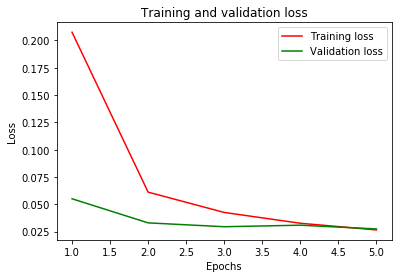

In [39]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, color='red', label='Training loss')
plt.plot(epochs, val_loss, color='green', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

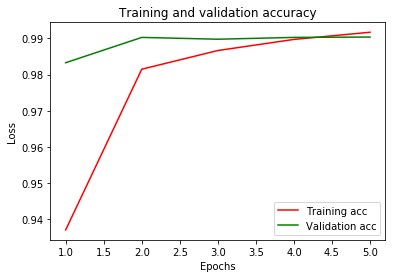

In [40]:
acc = history.history['acc']
val_acc = history.history['val_acc']
plt.plot(epochs, acc, color='red', label='Training acc')
plt.plot(epochs, val_acc, color='green', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [41]:
def layer_to_visualize(img_to_visualize, layer):
    # Keras requires the image to be in 4D, so we add an extra dimension to it.
    img_to_visualize = np.expand_dims(img_to_visualize, axis=0)
    
    inputs = [K.learning_phase()] + model.inputs

    _convout1_f = K.function(inputs, [layer.output])
    def convout1_f(X):
        # The [0] is to disable the training phase flag
        return _convout1_f([0] + [X])

    convolutions = convout1_f(img_to_visualize)
    convolutions = np.squeeze(convolutions)
    convolutions = convolutions.transpose(2, 0, 1)

    print('Shape of conv:', convolutions.shape)
    print(len(convolutions))
    
    n = convolutions.shape[0]
    n = int(np.ceil(np.sqrt(n)))
    
    # Visualization of each filter of the layer
    fig = plt.figure(figsize=(12,8))
    for i in range(len(convolutions)):
        ax = fig.add_subplot(n,n,i+1)
        ax.imshow(convolutions[i], cmap='gray')

Shape of conv: (32, 26, 26)
32
Shape of conv: (32, 13, 13)
32


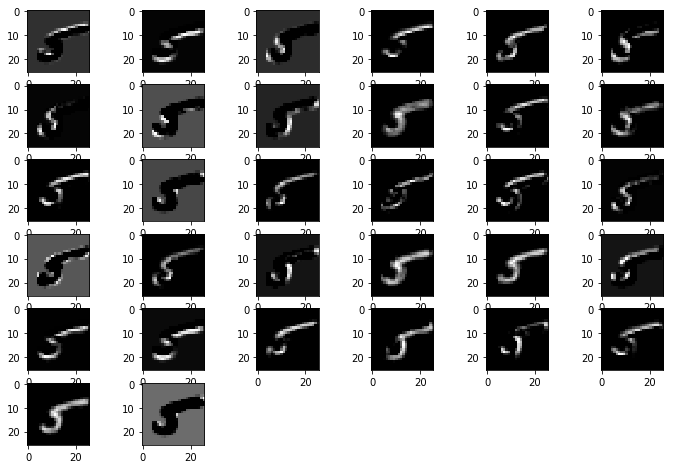

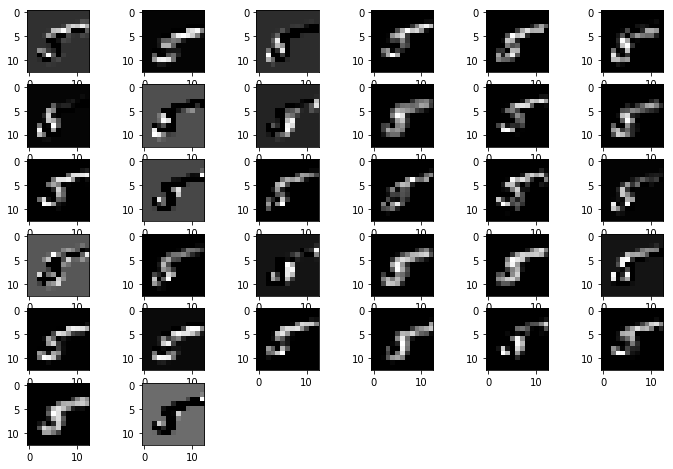

In [42]:
# Specify the layer to want to visualize
layer_to_visualize(X_train[65], convout1)

# As convout2 is the result of a MaxPool2D layer
# We can see that the image has blurred since
# the resolution has reduced 
layer_to_visualize(X_train[65], convout2)

In [43]:
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.027386883512960047
Test accuracy: 0.9904


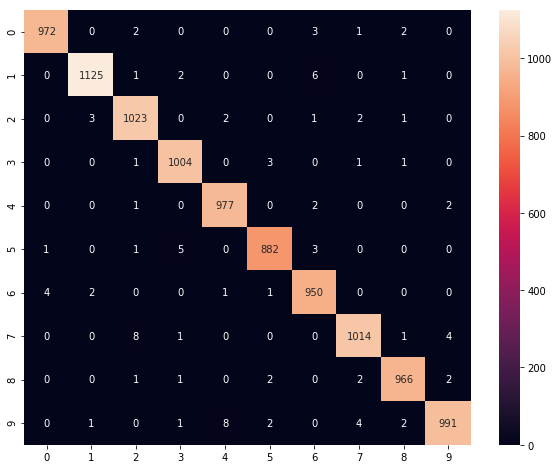

In [44]:
y_prob = model.predict(X_test) 
y_classes = y_prob.argmax(axis=-1)
label = np.argmax(Y_test, axis=1)
confusion_mtx = confusion_matrix(label, y_classes)
plt.figure(figsize=(10,8))
sns.heatmap(confusion_mtx, annot=True, fmt="d")

In [17]:
diff = y_classes-label
ind = np.where(diff!=0)
print(ind)
print(1-(len(diff[diff!=0]))/len(diff))

(array([  18,  247,  259,  321,  435,  445,  542,  582,  619,  659,  684,
        726,  740,  846,  882,  883,  947,  956,  965, 1014, 1039, 1112,
       1182, 1226, 1232, 1242, 1247, 1260, 1319, 1326, 1364, 1393, 1415,
       1522, 1530, 1549, 1553, 1709, 1717, 1754, 1790, 1878, 1901, 1941,
       1955, 1987, 2018, 2035, 2040, 2070, 2107, 2118, 2130, 2135, 2174,
       2182, 2225, 2272, 2280, 2293, 2387, 2406, 2414, 2454, 2488, 2597,
       2654, 2720, 2771, 2836, 2896, 2921, 2927, 2939, 2953, 3023, 3030,
       3060, 3073, 3206, 3289, 3377, 3422, 3503, 3520, 3550, 3558, 3559,
       3597, 3626, 3681, 3726, 3727, 3751, 3767, 3778, 3780, 3796, 3808,
       3906, 3941, 4075, 4176, 4248, 4497, 4500, 4507, 4536, 4571, 4575,
       4578, 4601, 4639, 4671, 4740, 4761, 4807, 4823, 4860, 5331, 5600,
       5634, 5734, 5749, 5887, 5937, 5955, 6004, 6091, 6166, 6555, 6597,
       6603, 6625, 6651, 6755, 7121, 8059, 8094, 8246, 8325, 8408, 8527,
       9009, 9015, 9019, 9024, 9280, 9634, 9664, 9

Shape of conv: (32, 26, 26)
32
Shape of conv: (32, 13, 13)
32
2 7


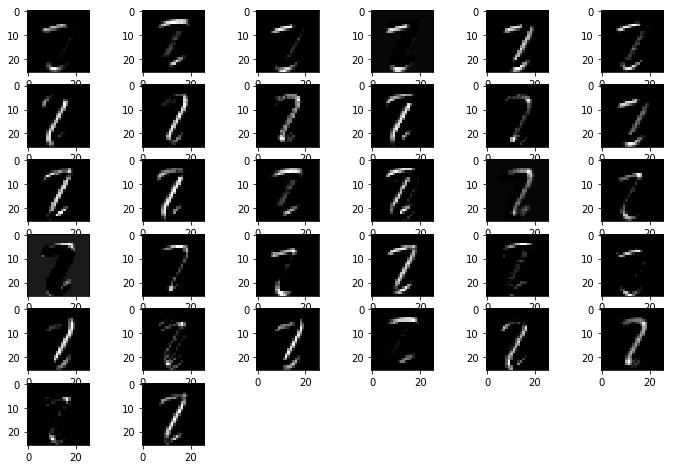

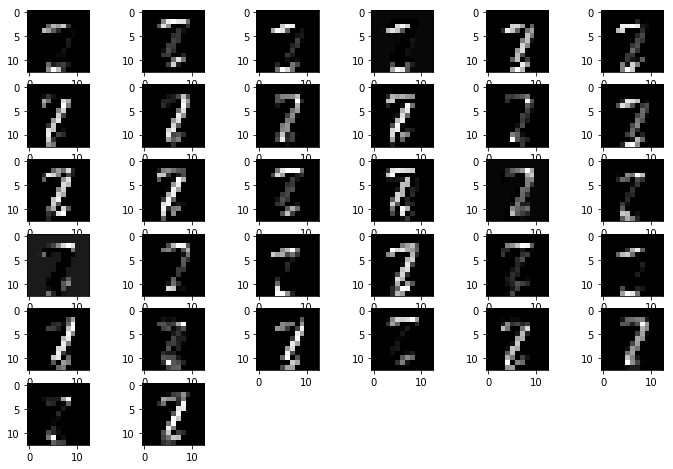

In [18]:
layer_to_visualize(X_test[321], convout1)
layer_to_visualize(X_test[321], convout2)
print(label[321], y_classes[321]) # true label vs predicted label (misclassified ones)

In [72]:
# train different model based on noisy labeled training data
history = model.fit(X_train, Y_train_noise, batch_size=128, nb_epoch=5, validation_data=(X_test, Y_test))

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:2: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 55000 samples, validate on 10000 samples
Epoch 1/5
55000/55000 [==============================] - 6s 108us/step - loss: 2.2174 - acc: 0.2561 - val_loss: 1.5009 - val_acc: 0.9445
Epoch 2/5
55000/55000 [==============================] - 5s 94us/step - loss: 2.1830 - acc: 0.2849 - val_loss: 1.4123 - val_acc: 0.9631
Epoch 3/5
55000/55000 [==============================] - 5s 93us/step - loss: 2.1711 - acc: 0.2889 - val_loss: 1.3222 - val_acc: 0.9663
Epoch 4/5
55000/55000 [==============================] - 5s 93us/step - loss: 2.1616 - acc: 0.2912 - val_loss: 1.3709 - val_acc: 0.9661
Epoch 5/5
55000/55000 [==============================] - 5s 94us/step - loss: 2.1510 - acc: 0.2931 - val_loss: 1.3718 - val_acc: 0.9659


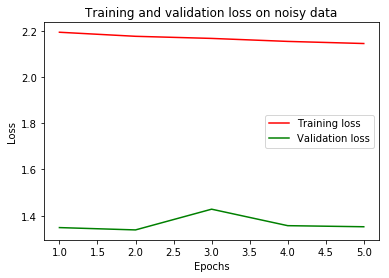

In [59]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, color='red', label='Training loss')
plt.plot(epochs, val_loss, color='green', label='Validation loss')
plt.title('Training and validation loss on noisy data')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

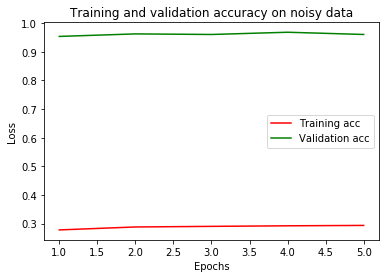

In [60]:
acc = history.history['acc']
val_acc = history.history['val_acc']
plt.plot(epochs, acc, color='red', label='Training acc')
plt.plot(epochs, val_acc, color='green', label='Validation acc')
plt.title('Training and validation accuracy on noisy data')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [73]:
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 1.3717837951660157
Test accuracy: 0.9659


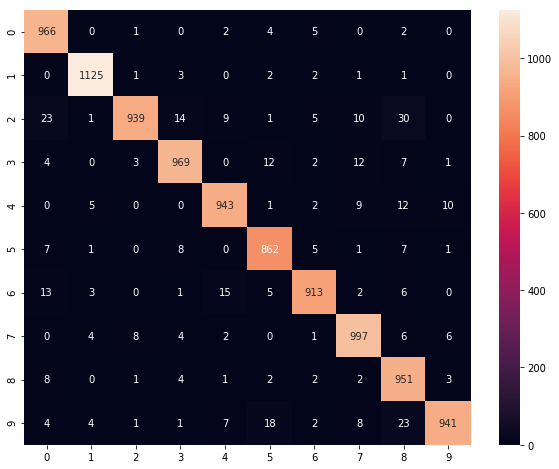

In [62]:
y_prob = model.predict(X_test) 
y_classes = y_prob.argmax(axis=-1)
label = np.argmax(Y_test, axis=1)
confusion_mtx = confusion_matrix(label, y_classes)
plt.figure(figsize=(10,8))
sns.heatmap(confusion_mtx, annot=True, fmt="d");

5 3
Shape of conv: (32, 26, 26)
32
Shape of conv: (32, 13, 13)
32


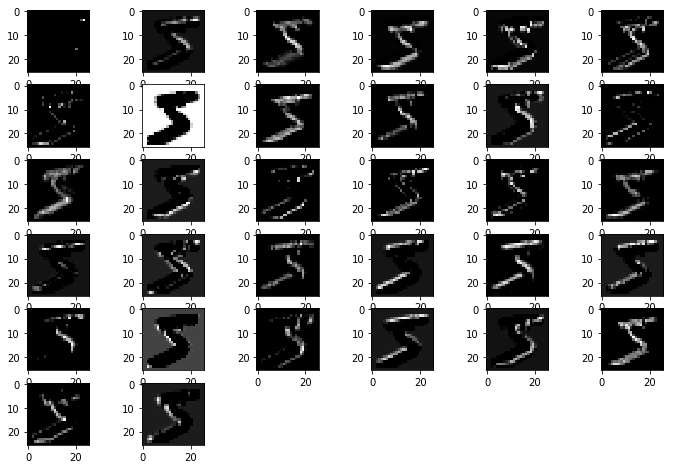

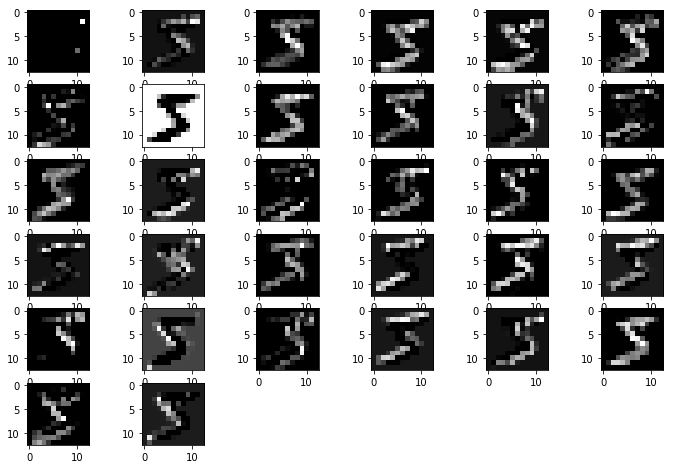

In [63]:
print(y_train[noisy_image_idx], y_train_noise[noisy_image_idx]) # true label vs noisy label
layer_to_visualize(X_train[noisy_image_idx], convout1)
layer_to_visualize(X_train[noisy_image_idx], convout2)

In [64]:
# visualize weights & compare statistics; validate pattern on more datasets (e.g. CIFAR)

In [ ]:
# majority vote ensemble learning (change cross accuracy checking for test set in last epoch)